In [1]:
library(data.table)
load('../data/exonicvsnon_counts.rda') # Probabilities of each mutation type
load('../data/gene_pd_exon.rda') # Load tables giving probability of insertion for each gene in a diploid genome for both genders
load('../data/tumor_type_driver_lists_cgc.rda')
source('./src_sompop_v0_2_4.r')
xy_genes <- gene_pd_m$gene_id[gene_pd_m$chrom %in% c('X','Y')] # Getting list of genes on chroms. X and Y by symbol

### Define parameters

In [5]:
###################################################3
# Gender of organism
gender <- 'male'

# Symbol of driver gene disrupted at t=0
driverGene <- ''

# List of driver genes
geneList <- as.vector(geneList_colon$Gene.Symbol)

# Initial number of cells
N0 <- 1e2

# Average # L1 insertions / cell cycle
mu <- 5
if (gender=='male') {
    mu <- mu*(1-pd_exvsnon_m[2])# Scale by 1-probability of null (intron) insertion, to convert to probability of exonic insertion
} else if (gender=='female') {
    mu <- mu*(1-pd_exvsnon_f[2])
}

# Selective strengths of each mutation type
spd <- 0.1 # Homozygous driver
spp <- 0.005 # Homozygous passenger
sld <- spd*0.1 # Heterozygous driver
slp <- spp*0.1 # Hetero. passenger

# Number of time steps to simulate
NT <- 5e3

###################################################3
# Time resolution: number of timesteps per generation
tau <- 1
tau <- 1/tau
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- N0*100
# Log path
logpath <- './test_v2.4.log'

## Test run

   user  system elapsed 
 91.142   0.016  91.161 


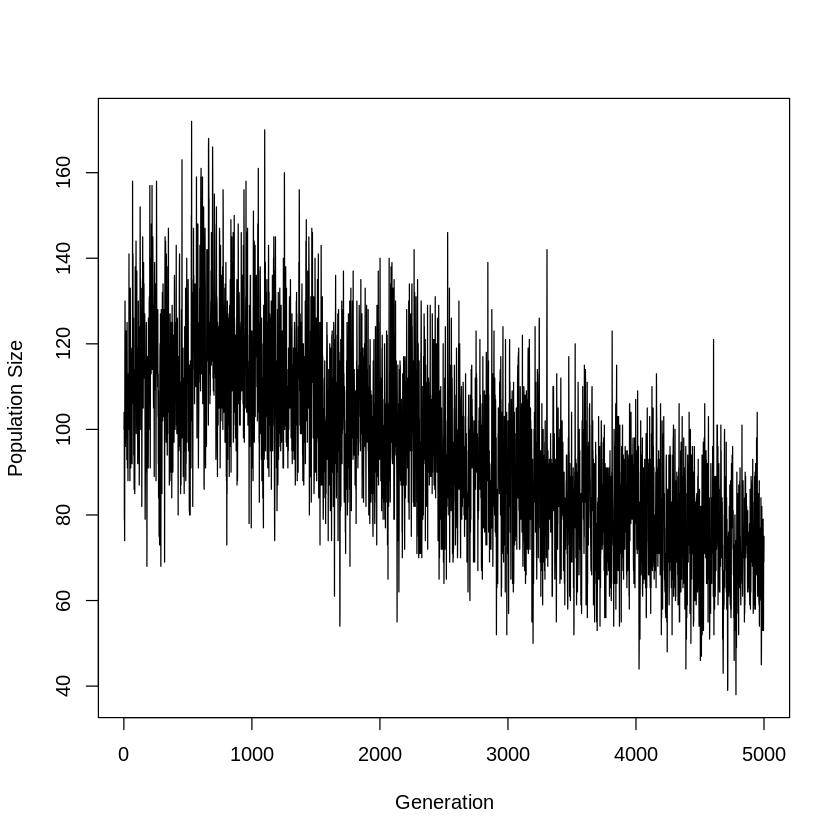

In [6]:
out <- sompop(N0, mu, tau, NT, sld, slp, spd, spp, gender, driverGene, geneList, maxNClones, logpath)
Pop <- out[[1]]
N <- out[[2]]
genTime <- out[[4]]

# head(Pop)
N[N==0] <- NA
genTime[genTime==0] <- NA
plot(1:NT*tau,N,type='l',xlab='Generation',ylab='Population Size')

## Batch run

In [ ]:
nrun <- 0

N0v <- c(5e2)
muv <- c(1)
if (gender=='male') {
    muv_adj <- muv*(1-pd_exvsnon_m[2])
} else if (gender=='female') {
    muv_adj <- muv*(1-pd_exvsnon_f[2])
}
sdv <- c(.1)
spv <- c(.005)
hef <- 0.1 # Fraction of homozygous effect assigned to heterozygous mutations

outPath <- '../../colon_test2/'
logPath <- paste0(outPath,'run.log')

tryCatch({
    for (ii in 1:length(N0v)){
        for (jj in 1:length(muv)) {
            for (ll in 1:length(sdv)) {
                for (mm in 1:length(spv)) {
                    for (nn in 1:100) {
                        nrun <- nrun+1
                        line <- paste0('Run: ',toString(nrun),'\tN0: ',toString(N0v[ii]),'\tmu: ',toString(muv[jj]),'\tsd: ',toString(sdv[ll]),'\tsp: ',toString(spv[mm]))
                        write(line,file=logPath,append=TRUE)
                        out <- sompop(N0v[ii], muv_adj[jj], tau, NT, sdv[ll]*hef, spv[mm]*hef, sdv[ll], spv[mm], gender, driverGene, geneList, N0v[ii]*4, logPath)
                        Pop <- out[[1]]
                        N <- out[[2]]
                        save(Pop,N,file=paste0(outPath,'run_n0',N0v[ii],'_',nrun,".rda"))
                        rm(Pop,N)
                    }
                }
            }
        }
    }
    }, warning = function(warn.msg){
        write(toString(warn.msg), logPath, append=TRUE)
    }, error = function(err.msg){
        write(toString(err.msg), logPath, append=TRUE)
    }
)